# Detecting COVID-19 with Chest X-Ray using PyTorch

Welcome to the COVID-19 Detection with Chest X-Ray using PyTorch project! This Cousera hands-on project is designed to help you master the essential skills for building a Convolutional Neural Network (CNN) to classify chest X-ray scans. By the end of this project, you’ll have the expertise to implement and train a ResNet-18 model to detect COVID-19 from X-ray images with high accuracy.

### Prerequisites:

+ Python Programming: Know the basics of Python and libraries like PyTorch, NumPy, and Matplotlib for model building and data handling.

+ Understand the theory behind how CNNs work with layers (convolution, activation, pooling) to process images and classify them.

+ Optimization Techniques: Get familiar with gradient descent, backpropagation, and loss functions (like cross-entropy loss) for model training.

### Project Structure:

The project is divided into the following parts:

+ **Introduction** Overview of the project, description of the dataset and limitations 
+ **Task 1: Importing Libraries** Setting up the environment and necessary dependencies
+ **Task 2: Creating Custom Dataset** Building a dataset class for the chest X-ray images
+ **Task 3: Image Transformations** Applying necessary transformations for data augmentation
+ **Task 4: Preparing the DataLoader** Organizing data for efficient training
+ **Task 5: Data Visualization** Visualizing the dataset to understand the distribution of images
+ **Task 6: Creating the Model** Implementing the ResNet-18 architecture
+ **Task 7: Training the Model** Training the model on the dataset and monitoring performance
+ **Task 8: Evaluating the Model** Analyzing results and fine-tuning the model for optimal performance



# Introduction

### Project Overview:

This project covers the following key concepts and techniques:

+ Creating a custom Dataset and DataLoader in PyTorch
+ Training  a ResNet-18 model for image classification
+ Image preprocessing and transformations to enhance model performance
+ Understanding the essentials of CNNs and their application in medical image classification

### Dataset Description:

The dataset is taken from here - [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)   (Kaggle).

This project utilizes a dataset created by researchers from Qatar University (Doha, Qatar), the University of Dhaka (Bangladesh), along with collaborators from Pakistan and Malaysia, in partnership with medical professionals. The dataset is specifically designed for COVID-19 detection using chest X-ray images, and it includes images from different categories to help train and test the model effectively.

It consists of the following classes of chest X-ray images:

1. COVID-19: X-ray images of patients with COVID-19 pneumonia.
2. Normal: Healthy individuals with no lung infections.
3. Viral Pneumonia: X-ray images of patients with other viral lung infections.

The dataset we utilise in this project consists of 219 COVID-19, 1341 normal, and 1345 viral pneumonia chest X-ray (CXR) images.

This dataset will continue to be updated as new chest X-ray images become available from COVID-19 pneumonia patients.

### Limitations:

While this project aims to provide a robust model for chest X-ray classification, it is mainly for learning purposes there are several limitations to consider:

1. The virus and its variants are continuously changing, which may impact the effectiveness of the model over time. As new mutations emerge, the model may require further updates and retraining with the latest data to maintain accuracy.

2. While the dataset used in this project is valuable, it is limited in size and diversity. A larger, more representative dataset with a wider range of COVID-19 variants and lung conditions would enhance the model’s ability to generalize across different patient populations and imaging conditions.

3. Medical Guidance is Necessary: This model is designed to assist with early detection, but it is not a replacement for professional medical evaluation. The final diagnosis should always be made by a healthcare professional, as the model is not foolproof and may have limitations in certain cases.



# Task 1: Importing Libraries

In [1]:
# Ensures that the matplotlib plots are displayed directly below the code cell.
%matplotlib inline

import os # Interacts with the operating system (To navigate files and directories, like creating folders or checking if a file exists).
import shutil # High-level file operations (copying, moving or deleting files and directories).
import random # To generate random numbers or shuffle data (Useful for splitting data into training and test sets randomly).
import torch # PyTorch: Provides tools to handle tensors (multi-dimensional arrays) and run computations on GPUs for speed.
import torchvision # PyTorch add-on for image processing (datasets, models).
import torchvision.transforms as transforms
import numpy as np  # Numerical computations and arrays.

from PIL import Image # For image manipulation (open, modify, and save image files).
from matplotlib import pyplot as plt # For creating visualizations.

torch.manual_seed(0) # Sets the random seed for reproducible PyTorch results.

print('Using PyTorch version', torch.__version__) # It's good to know because some features may vary between versions.

Using PyTorch version 2.3.1+cu121


### Preparing Training and Test Sets

In [2]:
# Note: The dataset does not come with predefined training, validation, or test sets.  
# For simplicity, we are creating two sets: training and test.  
# Normally, a separate validation set is used for model tuning, and the test set is reserved for final evaluation.  
# However, for this project, we will use the test set for both validation and testing purposes.

# Note: The number of COVID-19 images is significantly smaller compared to other classes.  
# This creates a class imbalance, which could lead to the model favoring the larger classes.  

In [3]:
# Define the categories (class names) for the images
class_names = ['normal', 'viral', 'covid']

# Root folder where the dataset is stored
root_dir = 'COVID-19 Radiography Database'

# Original folder names in the dataset
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

# Check if the 'Viral Pneumonia' folder exists in the root folder
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    
    # Create a new 'test' folder inside the root directory to store test images
    os.mkdir(os.path.join(root_dir, 'test'))

    # Rename the original folders to match the new class names
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    # Create subfolders inside the 'test' folder for each class (normal, viral, covid)
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    # Move 30 random images from each class into the 'test' subfolders
    for c in class_names:
        # Get a list of all .png image files in the class folder
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        
        # Randomly pick 30 images from the class folder
        selected_images = random.sample(images, 30)
        
        for image in selected_images:
            # Define where the image is currently and where to move it
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            
            # Move the selected image to the corresponding 'test' subfolder
            shutil.move(source_path, target_path)


# Task 2: Creating Custom Dataset

In [4]:
# Define a custom PyTorch Dataset class for loading chest X-ray images
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        """
        Initializes the dataset.

        Parameters:
        - image_dirs (dict): A dictionary mapping class names ('normal', 'viral', 'covid') 
                             to their corresponding directory paths.
        - transform (callable): A function or transform pipeline to apply to the images.
        This is used for data augmentation during training, but for testing, it will
        only convert the images to tensors and normalize the pixel values.
        """
             
        def get_images(class_name):
            """
            Helper function to list all .png images in a given directory.

            Parameters:
            - class_name (str): The class name whose images are to be listed.

            Returns:
            - A list of image filenames in the given class directory.
            """
            # Get all .png images from the directory of the specified class
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')  # Print the count for debugging
            return images
    
        
        # Initialize dictionary to hold image filenames for each class
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']  # Define the class labels
        
        # Populate the dictionary with image filenames for each class
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
        
        # Store the directories and transformation pipeline
        self.image_dirs = image_dirs
        self.transform = transform

    
    def __len__(self):
        """
        Returns the total number of images in the dataset.

        This is the sum of the number of images in all classes.
        """
        return sum([len(self.images[class_name]) for class_name in self.class_names])

    def __getitem__(self, index):
        """
        Fetches an image and its label based on the given index.

        Parameters:
        - index (int): Index of the image to retrieve.

        Returns:
        - A tuple (image, label), where:
          - image is the transformed image tensor.
          - label is the integer class index corresponding to the image class.
        """
        # Randomly select a class to ensure balanced sampling
        class_name = random.choice(self.class_names)
        
        # Adjust the index to stay within the bounds of the chosen class's image list
        index = index % len(self.images[class_name])
        
        # Retrieve the image filename and construct the full path
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        
        # Open the image using Pillow and convert it to RGB format
        image = Image.open(image_path).convert('RGB')
        
        # Apply the transformation pipeline to the image
        transformed_image = self.transform(image)
        
        # Return the transformed image and the corresponding class index
        return transformed_image, self.class_names.index(class_name)
    
    
# Note: Handling class imbalance: Use the remainder of the index divided by the number of images in each class
# This ensures that even when the dataset index is larger than the number of images in any class,
# we won't go out of bounds, as the remainder will cycle through available images.
    

# Task 3: Image Transformations

In [5]:
# Training transformations with augmentation
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # Resize images to (224, 224) for model input size
    transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally to augment the data
    transforms.ToTensor(),               # Convert the image to a tensor 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to standard ImageNet values
])

# Testing transformations (no augmentation, only normalization)
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # Resize images to (224, 224) for model input size
    transforms.ToTensor(),               # Convert the image to a tensor 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to standard ImageNet values
])


# Task 4: Prepare DataLoader

In [6]:
# A DataLoader in PyTorch is a utility that helps you efficiently load and manage your dataset in batches.
# We utilize it to efficiently load and manage chest X-ray images during both training and testing.

# Define the directory paths for each class (normal, viral, covid)
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',  
    'viral': 'COVID-19 Radiography Database/viral',    
    'covid': 'COVID-19 Radiography Database/covid'   
}

# Initialize the custom dataset for training with paths and transformations
train_dataset = ChestXRayDataset(train_dirs, train_transform) 


Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [7]:
# Directory paths for test set (normal, viral, covid)
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

# Initialize the test dataset with paths and transformations
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [8]:
# Set batch size for training and testing
batch_size = 6

# DataLoader for training and testing with shuffling (shuffles indices)
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Print the number of batches in training and test datasets
print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))


Number of training batches 470
Number of test batches 15


# Task 5: Data Visualization

In [9]:
# List of class names for reference (normal, viral, covid)
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    # Display images with their true and predicted labels
    plt.figure(figsize=(8, 4))
    
    for i, image in enumerate(images):
        # Create subplot for each image
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        
        # PyTorch stores images in the format (C, H, W), where:
        # C is the number of channels (e.g., 3 for RGB images), H is the height of the image and W is the width of the image.
        # But matplotlib expects images in the format (H, W, C) to display them properly.
        #.transpose((1, 2, 0)) changes the image's shape from (C, H, W) to (H, W, C) by swapping the axis order.
        
        # Convert the image from tensor format to a NumPy array and denormalize
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean  # Denormalize to get the original image
        image = np.clip(image, 0., 1.)  # Ensure pixel values are in the range [0, 1]
        
        # Display the image
        plt.imshow(image)
        
        # Set label color to green if prediction matches, red if it doesn't
        col = 'green' if preds[i] == labels[i] else 'red'
        
        # Display true label and predicted label with color coding
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    
    plt.tight_layout()  # Adjust spacing
    plt.show()  # Show the images


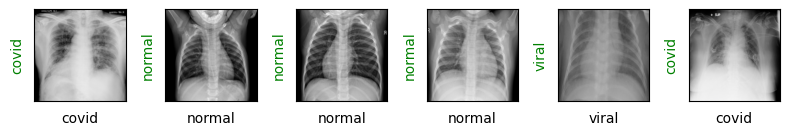

In [10]:
# Fetch a single batch of images and labels from the training DataLoader
images, labels = next(iter(dl_train))

# Display the images with true labels and predicted labels (predictions are same as true labels here)
show_images(images, labels, labels)

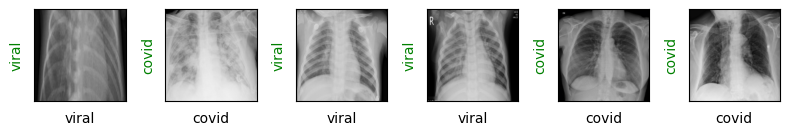

In [11]:
# Fetch the next batch of images and labels from the test DataLoader
images, labels = next(iter(dl_test))

# Show the images with their true labels (preds == labels here, so they'll be green)
show_images(images, labels, labels)


# Task 6: Creating the Model

In [12]:
resnet18 = torchvision.models.resnet18(pretrained=True) # Downloads a version of the model pre-trained on the ImageNet dataset

print(resnet18) # Prints the architecture of the ResNet-18 model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 267MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Modify the final fully connected (fc) layer to output 3 classes (normal, viral, covid)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

# Define the loss function (Cross Entropy Loss) for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set up the optimizer (Adam optimizer) to update model parameters during training
# The learning rate is set to 3e-5 for fine-tuning
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)


In [14]:
def show_preds():
    # Set the model to evaluation mode (disables dropout, batch norm updates, etc.)
    resnet18.eval()

    # Fetch a batch of test images and their true labels
    images, labels = next(iter(dl_test))

    # Perform a forward pass through the model to get predictions
    outputs = resnet18(images)

    # Get the predicted class index for each image
    # torch.max returns both the max value and the index of the max value
    _, preds = torch.max(outputs, 1)

    # Visualize the images along with their true and predicted labels
    show_images(images, labels, preds)


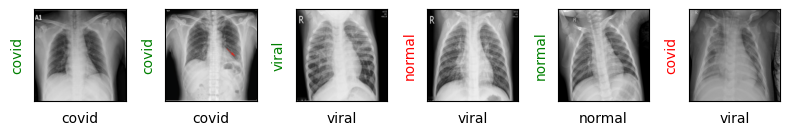

In [15]:
show_preds()

# Task 7: Training the Model

In [16]:
def train(epochs):
    print('Starting training..')
    
    # Loop through each epoch
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        # Initialize loss trackers for training and validation
        train_loss = 0.
        val_loss = 0.

        resnet18.train()  # Set model to training phase

        # Loop through each batch in the training DataLoader
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()  # Zero gradients before backpropagation
            outputs = resnet18(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagate gradients
            optimizer.step()  # Update model parameters

            train_loss += loss.item()  # Accumulate training loss
            
            # Evaluate every 20 steps to monitor progress
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval()  # Set model to evaluation phase

                # Loop through each batch in the test DataLoader for validation
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)  # Forward pass on validation data
                    loss = loss_fn(outputs, labels)  # Compute validation loss
                    val_loss += loss.item()  # Accumulate validation loss

                    _, preds = torch.max(outputs, 1)  # Get predicted class
                    accuracy += sum((preds == labels).numpy())  # Calculate accuracy

                # Average validation loss and accuracy over all batches
                val_loss /= (val_step + 1)
                accuracy = accuracy / len(test_dataset)

                # Print validation results
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                
                # Show images with predictions to visually check performance
                show_preds()

                resnet18.train()  # Switch back to training mode

                # Stop training if accuracy condition is satisfied (95%+)
                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        # Average training loss for this epoch
        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.1811, Accuracy: 0.2778


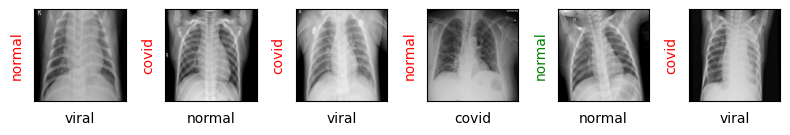

Evaluating at step 20
Validation Loss: 0.5874, Accuracy: 0.8667


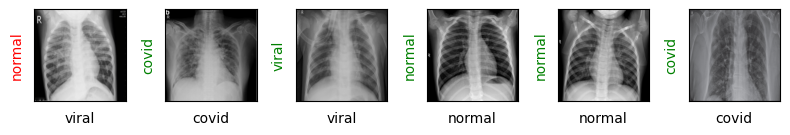

Evaluating at step 40
Validation Loss: 0.2439, Accuracy: 0.9667


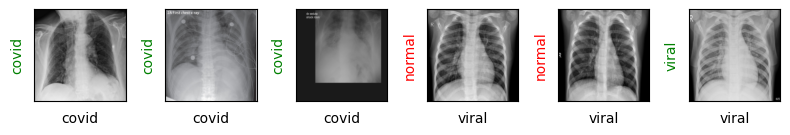

Performance condition satisfied, stopping..
CPU times: user 3min 29s, sys: 3.72 s, total: 3min 33s
Wall time: 1min 46s


In [17]:
%%time

train(epochs = 1)

# Task 8: Final Results

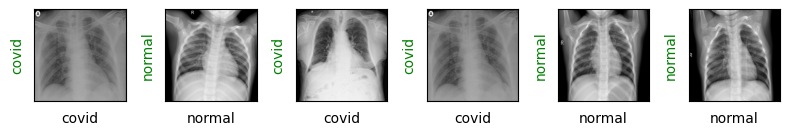

In [18]:
show_preds()